# Grad-CAM (Another version)

### - Import

In [ ]:
import torch
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.autograd import Function

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os

import datetime

print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2


### - Loading Model: Densenet121

In [ ]:
class TransferDenseNet(nn.Module):
    def __init__ (self, num_classes):
        super(TransferDenseNet, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        num_feature = torchvision.models.densenet121(pretrained=True).classifier.in_features
        self.densenet.classifier = nn.Linear(num_feature, num_classes)
        
    def forward(self,x):
        return self.densenet(x)

In [ ]:
densenet121_test = TransferDenseNet(num_classes=4).to(device) 
model_path = './saved/ckpoint_37_100.0%.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print('loss: ', checkpoint['loss'])
densenet121_test.load_state_dict(state_dict)
densenet121_test.eval()

loss:  tensor(0.0088)


TransferDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

### - Image Loading

../data/OCT\test\DRUSEN\DRUSEN-7555604-2.jpeg


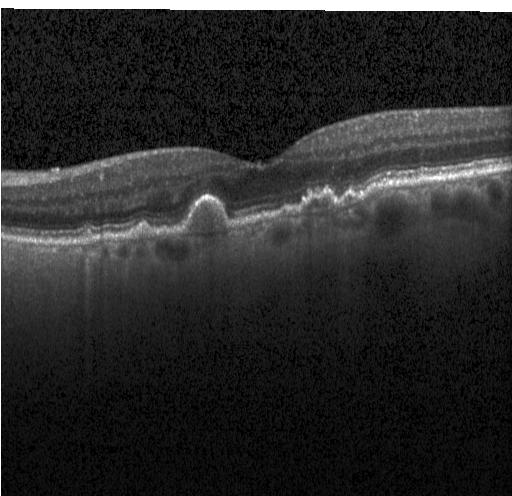

In [ ]:
data_dir = '../data/OCT'
test_dir_name = 'test'
test_img_list = sorted(glob.glob(os.path.join(data_dir, test_dir_name, '*','*')))
img_idx = np.random.randint(len(test_img_list))
test_img_path = test_img_list[img_idx]
print(test_img_path)

pil_img = Image.open(test_img_path)
pil_img

### - Make directory for saving

In [ ]:
current_time = datetime.datetime.now()
str_time = str(current_time.year)+str('_{0:02d}_'.format(current_time.month))+str('{0:02d}__'.format(current_time.day))+str('{0:02d}_'.format(current_time.hour))+str('{0:02d}'.format(current_time.minute))
dir_name = 'GradCAM_'+str_time

saved_loc = os.path.join('./output/GradCAM', dir_name)
if os.path.exists(saved_loc):
    user_input = input('Warning! rmtree 메소드는 하위 디렉토리 및 모든파일들을 삭제합니다. 계속하겠습니까? (y/n): ')
    if user_input == 'y':
        shutil.rmtree(saved_loc)
    else:
        print('중단되었습니다.')
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

결과 저장 위치:  ./output/GradCAM\GradCAM_2024_05_06__23_51


### - Normalize Image

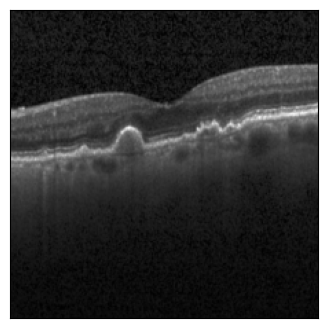

In [ ]:
def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Mean and std for OCT images
train_mean = 0.1881
train_std = 0.1850

normalizer = Normalize(mean=[train_mean, train_mean, train_mean], std=[train_std, train_std, train_std])
transformation = transforms.Compose([
            transforms.Resize([256]),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
torch_img = transformation(pil_img).squeeze()                                # (1, 224, 224)
torch_img = torch.stack((torch_img, torch_img, torch_img), dim=0).unsqueeze(0)      # (1, 3, 224, 224)
normed_torch_img = normalizer(torch_img) # (1, 3, 224, 224)

trans_for_visualize = transforms.Compose([
            transforms.Resize([256]),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
img = trans_for_visualize(pil_img).squeeze()    # (1, 224, 224)
img = torch.stack((img, img, img), dim=0)       # (3, 224, 224)

img = np.transpose(img.cpu().numpy().squeeze(), (1, 2, 0)) # (224, 224, 3)
plt.imshow(img)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [ ]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

### - Grad-CAM

- https://cumulu-s.tistory.com/41
- https://github.com/PeterKim1/paper_code_review/tree/master/9.%20Visual%20Explanations%20from%20Deep%20Networks%20via%20Gradient-based%20Localization(Grad-CAM)

 - Guided Backpropagation

In [ ]:
class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask = (input_img > 0).type_as(input_img)
        
        # torch.addcmul(input, tensor1, tensor2) => output = input + tensor1 x tensor 2
        # input image와 동일한 사이즈의 torch.zeros를 만든 뒤, input image와 positive_mask를 곱해서 output 생성
        # 결국은 ReLU와 동일한 효과
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        
        # backward에서 사용될 forward의 input이나 output을 저장
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        
        # forward에서 저장된 saved tensor를 불러오기
        input_img, output = self.saved_tensors
        grad_input = None

        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_1 = (input_img > 0).type_as(grad_output)
        
        # 모델의 결과 (gradient)가 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        
        # 먼저 모델의 결과와 positive_mask_1과 곱해주고,
        # 다음으로는 positive_mask_2와 곱해줘서 
        # 모델의 결과가 양수이면서 input image가 양수인 부분만 남도록 만들어줌
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

- Exchange ReLU to Guided backprop ReLU in specific model

In [ ]:
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):        # target_category에 원하는 class를 넣기
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1 # target_category에 해당하는 번째의 숫자만 1이고 나머지는 다 0
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)   # 원하는 output에 대한 예측만 빼냄
        # 모델이 예측한 결과값을 기준으로 backward 진행
        one_hot.backward(retain_graph=True)

        # input image의 gradient를 저장
        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))
        return output

- Forward and backward hook

In [ ]:
# final conv layer name 
finalconv_name = 'norm5'

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])
    

densenet121_test.densenet.features._modules.get(finalconv_name).register_forward_hook(hook_feature)
densenet121_test.densenet.features._modules.get(finalconv_name).register_backward_hook(backward_hook)

- Perform forward and backward

In [ ]:
# get the softmax weight
params = list(densenet121_test.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy())
# Prediction
logit = densenet121_test(normed_torch_img)
h_x = F.softmax(logit, dim=1).data.squeeze() # softmax 적용

c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


- Grad-CAM Main Lines

In [ ]:
_, argmax = torch.max(logit, 1)
label_index = argmax.item() # 0: Normal, 1: CNV, 2: DME, 3:Drusen
print(label_index)

score = logit[:, label_index].squeeze() # 예측값 y^c
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

3


In [ ]:
print(np.unique(np.array(feature_blobs)))

[0.0000000e+00 6.4492226e-05 6.3091516e-04 ... 9.5182409e+00 9.8126001e+00
 9.9019442e+00]


In [ ]:
print(np.array(feature_blobs).shape)

(1, 1, 1024, 7, 7)


In [ ]:
print(np.array(backward_feature).shape)

(1, 1, 1024, 7, 7)


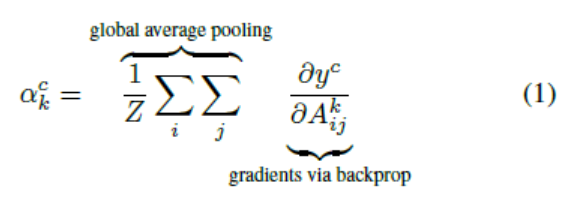

In [ ]:
activations = feature_blobs[0].to(device) # (1, 1024, 7, 7), forward pass를 진행하면서 얻게 되는 마지막 conv layer의 feature map: forward activations
gradients = backward_feature[0] # (1, 1024, 7, 7), 마지막 conv layer의 feature map의 gradient, backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 1024, 7*7) => (1, 1024), feature map k의 'importance'를 의미
                                        # 3번째 차원을 기준으로 평균내기
weights = alpha.view(b, k, 1, 1) # (1, 1024, 1, 1)

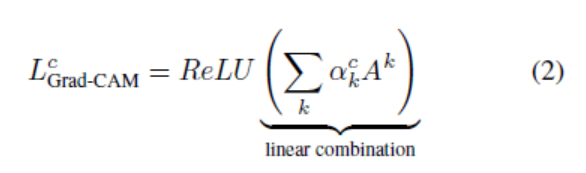

In [ ]:
# Linear combination
grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 1024, 7, 7) => (1, 1, 7, 7): 두 번째 차원으로 더해주기
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U -> 여기까지가 위쪽 (2)번식 구현
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)로 Upsampling
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

In [ ]:
# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy

# Grad-CAM heatmap save
cv2.imwrite(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg"), grad_heatmap)

grad_heatmap = np.float32(grad_heatmap) / 255

grad_result = grad_heatmap + img
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)

# Grad-CAM Result save
cv2.imwrite(os.path.join(saved_loc, "Grad_Result.jpg"), grad_result)

True

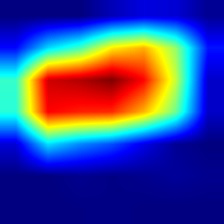

In [ ]:
Image.open(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg"))

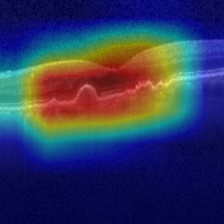

In [ ]:
Image.open(os.path.join(saved_loc, "Grad_Result.jpg"))

In [ ]:
# ==Guided-Backprop main lines= #
# gb_model => ReLU function in resnet50 change to GuidedBackpropReLU.
gb_model = GuidedBackpropReLUModel(model=densenet121_test, use_cuda=False)    # densenet121_test내 ReLU를 GuidedBackpropReLU로 바꾸기
gb_num = gb_model(torch_img, target_category = label_index) # 이 모델에 image를 투입하여 얻게 되는 Guided Backpropagation 이미지는 gb_num
gb = deprocess_image(gb_num) # (224, 224, 3), numpy

# Guided Backprop save
cv2.imwrite(os.path.join(saved_loc, "Guided_Backprop.jpg"), gb)

True

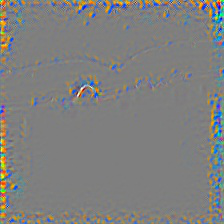

In [ ]:
Image.open(os.path.join(saved_loc, "Guided_Backprop.jpg"))

In [ ]:
# Guided-Backpropagation * Grad-CAM => Guided Grad-CAM 
# See Fig. 2 in paper.
# grad_cam_map : (1, 1, 224, 224) , torch.Tensor
grayscale_cam = grad_cam_map.squeeze(0).cpu().numpy() # (1, 224, 224), numpy
grayscale_cam = grayscale_cam[0, :] # (224, 224)
cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam]) # (224, 224, 3) 이렇게 합쳐주기

cam_gb = deprocess_image(cam_mask * gb_num) # Guidedbackpropmodel에 img 투입해서 얻은 output인 gb_num과 mask를 곱하기

# Guided Grad-CAM save
cv2.imwrite(os.path.join(saved_loc, "Guided_Grad_CAM.jpg"), cam_gb)

True

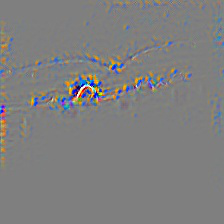

In [ ]:
Image.open(os.path.join(saved_loc, "Guided_Grad_CAM.jpg"))

- Final Result

<Fig 1> in article
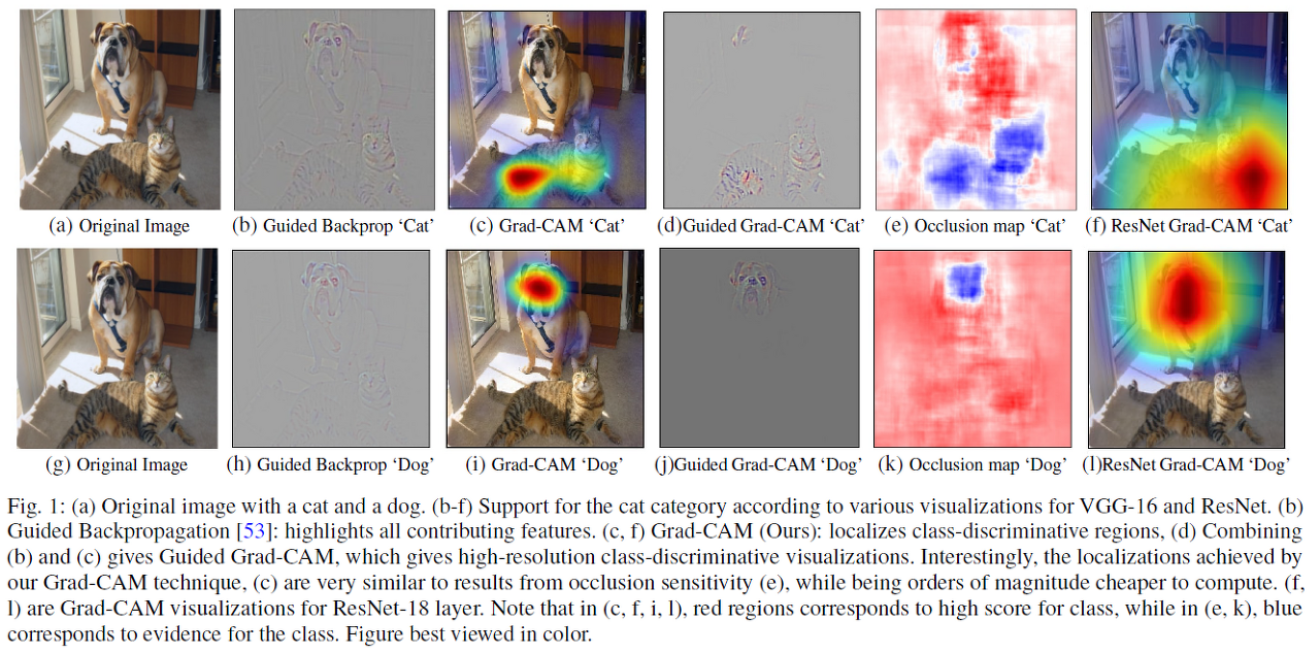

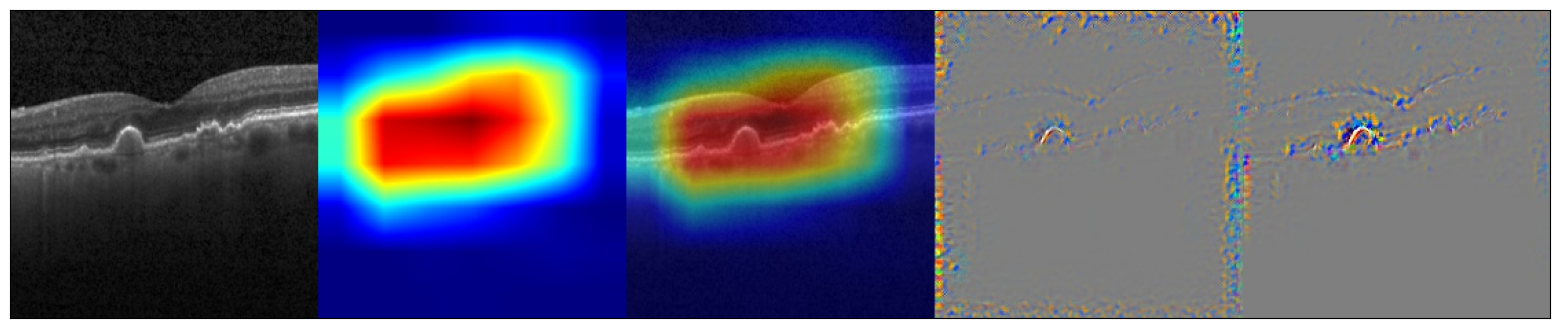

In [ ]:
pil_img = Image.open(test_img_path)
pil_transform = transforms.Compose([
            transforms.Resize([256]),
            transforms.CenterCrop(224),
        ])

Original_image = cv2.cvtColor(np.array(pil_transform(pil_img)), cv2.COLOR_RGB2BGR) # Pil -> Open CV
G_heatmap = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg")), cv2.COLOR_BGR2RGB)
G_result = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Grad_Result.jpg")), cv2.COLOR_BGR2RGB)
G_Back = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Guided_Backprop.jpg")), cv2.COLOR_BGR2RGB)
G_CAM = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Guided_Grad_CAM.jpg")), cv2.COLOR_BGR2RGB)

Total = cv2.hconcat([Original_image, G_heatmap, G_result, G_Back, G_CAM])

plt.rcParams["figure.figsize"] = (20, 4)
plt.imshow(Total)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig(os.path.join(saved_loc, "Final_result.jpg"))
plt.show()

# 왼쪽에서부터 input - Grad-CAM - Grad-CAM - Guide-backprop - Guide-Grad-CAM 순서